# 目次

- データ確認
- エンコーディング
  1. One-Hotエンコーディング
  2. ダミーコーディング
  3. Effectエンコーディング
  4. Labelエンコーディング
  5. Ordinlエンコーディング
  6. カウントエンコーディング
  7. カウントラベルエンコーディング
  8. ビンカウンティング
  9. Nonエンコーディング

# ライブラリ群

In [ ]:
# データ処理
import csv
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format
from sklearn.preprocessing import StandardScaler

# アルゴリズム

# 評価
from sklearn import metrics

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
# スタイル・フォントの調整
plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
plt.rc('font', **font)
rcParams['font.family'] = 'sans-serif'
# 日本語対応
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# データ確認

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
sample_submission = pd.read_csv("./sample_submission.csv")

In [3]:
train_df.shape
train_df.head()

test_df.shape
test_df.head()

sample_submission.shape
sample_submission.head()

(1460, 81)

ID  MSサブクラス MSエリア分割  たくさんの間口  ロットエリア     街   路地 ロット形状 土地の等高線 ユーティリティ  ...  \
0   1       60      RL       65    8450  Pave  NaN   Reg    Lvl  AllPub  ...   
1   2       20      RL       80    9600  Pave  NaN   Reg    Lvl  AllPub  ...   
2   3       60      RL       68   11250  Pave  NaN   IR1    Lvl  AllPub  ...   
3   4       70      RL       60    9550  Pave  NaN   IR1    Lvl  AllPub  ...   
4   5       60      RL       84   14260  Pave  NaN   IR1    Lvl  AllPub  ...   

  プールエリア プールの品質管理 フェンス その他の機能 その他のヴァル 販売月   販売年  販売タイプ     販売条件  セールスプライス  
0      0      NaN  NaN    NaN       0   2  2008     WD   Normal    208500  
1      0      NaN  NaN    NaN       0   5  2007     WD   Normal    181500  
2      0      NaN  NaN    NaN       0   9  2008     WD   Normal    223500  
3      0      NaN  NaN    NaN       0   2  2006     WD  Abnorml    140000  
4      0      NaN  NaN    NaN       0  12  2008     WD   Normal    250000  

[5 rows x 81 columns]

(1459, 80)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH           80    11622   Pave   NaN      Reg   
1  1462          20       RL           81    14267   Pave   NaN      IR1   
2  1463          60       RL           74    13830   Pave   NaN      IR1   
3  1464          60       RL           78     9978   Pave   NaN      IR1   
4  1465         120       RL           43     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

(1459, 2)

Id  SalePrice
0  1461     169277
1  1462     187758
2  1463     183584
3  1464     179317
4  1465     150730

In [4]:
# レコード件数比較用の関数
def show_graph(labels, records, color, va):
    graph = plt.bar(labels, records, color=color)

    def autolabel(graph):
        for rect in graph:
            labels = rect.get_height()
            plt.annotate('{}'.format(labels),
                xy=(rect.get_x() + rect.get_width() / 2, labels),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va=va)

    plt.grid()
    autolabel(graph);

レコード件数をプロット


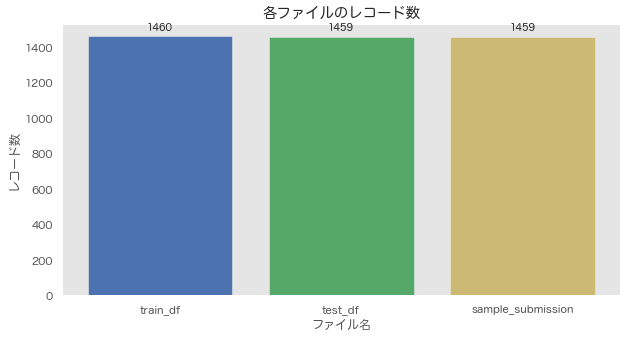

In [5]:
print('レコード件数をプロット')
x1=len(train_df)
x2=len(test_df)
x3=len(sample_submission)
records=[x1,x2,x3]
labels=['train_df','test_df','sample_submission']
color=['b','g','y']
va='bottom'

plt.figure(figsize=[10,5])
plt.title('各ファイルのレコード数')
plt.xlabel('ファイル名')
plt.ylabel('レコード数')
show_graph(labels, records, color, va);

In [6]:
# 欠損値
# train
missing_values1 = pd.DataFrame()
for column in train_df.columns:
    missing_values1[column] = [train_df[train_df[column].isnull()].shape[0]]
missing_values1.T.head(50)
missing_values1.T.tail(31)

0
ID               0
MSサブクラス          0
MSエリア分割          0
たくさんの間口        259
ロットエリア           0
街                0
路地            1369
ロット形状            0
土地の等高線           0
ユーティリティ          0
ロット構成            0
土地の傾斜            0
近所               0
状態1              0
条件2              0
ビルタイプ            0
ハウススタイル          0
全体的な品質           0
全体的な状態           0
建てられた年           0
年変更追加            0
ルーフスタイル          0
ルーフマット           0
エクステリア1位         0
エクステリア2位         0
MasVnrタイプ        8
MasVnrエリア        8
外部の品質            0
外部の条件            0
財団               0
地下室の品質          37
地下室の状態          37
地下室の露出          38
地下室のフィンタイプ1     37
地下フィンSF1         0
地下室のフィンタイプ2     38
地下フィンSF2         0
地下室UnfSF         0
地下室合計SF          0
暖房               0
暖房品質管理           0
セントラルエア          0
電気               1
1階SF             0
2階SF             0
低品質のフィンSF        0
グラウンドリビングエリア     0
地下フルバスルーム        0
地下ハーフバスルーム       0
フルバスルーム          0

0
ハーフバスルーム          0
ベッドルームアルコール度数     0
キッチンアルコール度数       0
キッチンクォール          0
グレード以上の総部屋数       0
機能的               0
暖炉                0
暖炉の品質           690
ガレージタイプ          81
ガレージYrBlt        81
ガレージ仕上げ          81
ガレージカー            0
ガレージエリア           0
ガレージの品質          81
ガレージコンディション      81
舗装されたドライブ         0
ウッドデッキSF          0
オープンポーチSF         0
囲まれたポーチ           0
社会保障番号ポーチ         0
スクリーンポーチ          0
プールエリア            0
プールの品質管理       1453
フェンス           1179
その他の機能         1406
その他のヴァル           0
販売月               0
販売年               0
販売タイプ             0
販売条件              0
セールスプライス          0

In [7]:
# test
missing_values2 = pd.DataFrame()
for column in test_df.columns:
    missing_values2[column] = [test_df[test_df[column].isnull()].shape[0]]
missing_values2.T.head(50)
missing_values2.T.tail(30)

0
Id               0
MSSubClass       0
MSZoning         4
LotFrontage    227
LotArea          0
Street           0
Alley         1352
LotShape         0
LandContour      0
Utilities        2
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      1
Exterior2nd      1
MasVnrType      16
MasVnrArea      15
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual        44
BsmtCond        45
BsmtExposure    44
BsmtFinType1    42
BsmtFinSF1       1
BsmtFinType2    42
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     2
BsmtHalfBath     2
FullBath         0

0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
KitchenQual       1
TotRmsAbvGrd      0
Functional        2
Fireplaces        0
FireplaceQu     730
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
PavedDrive        0
WoodDeckSF        0
OpenPorchSF       0
EnclosedPorch     0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
PoolQC         1456
Fence          1169
MiscFeature    1408
MiscVal           0
MoSold            0
YrSold            0
SaleType          1
SaleCondition     0

In [8]:
# sample_submission
missing_values3 = pd.DataFrame()
for column in sample_submission.columns:
    missing_values3[column] = [sample_submission[sample_submission[column].isnull()].shape[0]]
missing_values3.T

0
Id         0
SalePrice  0

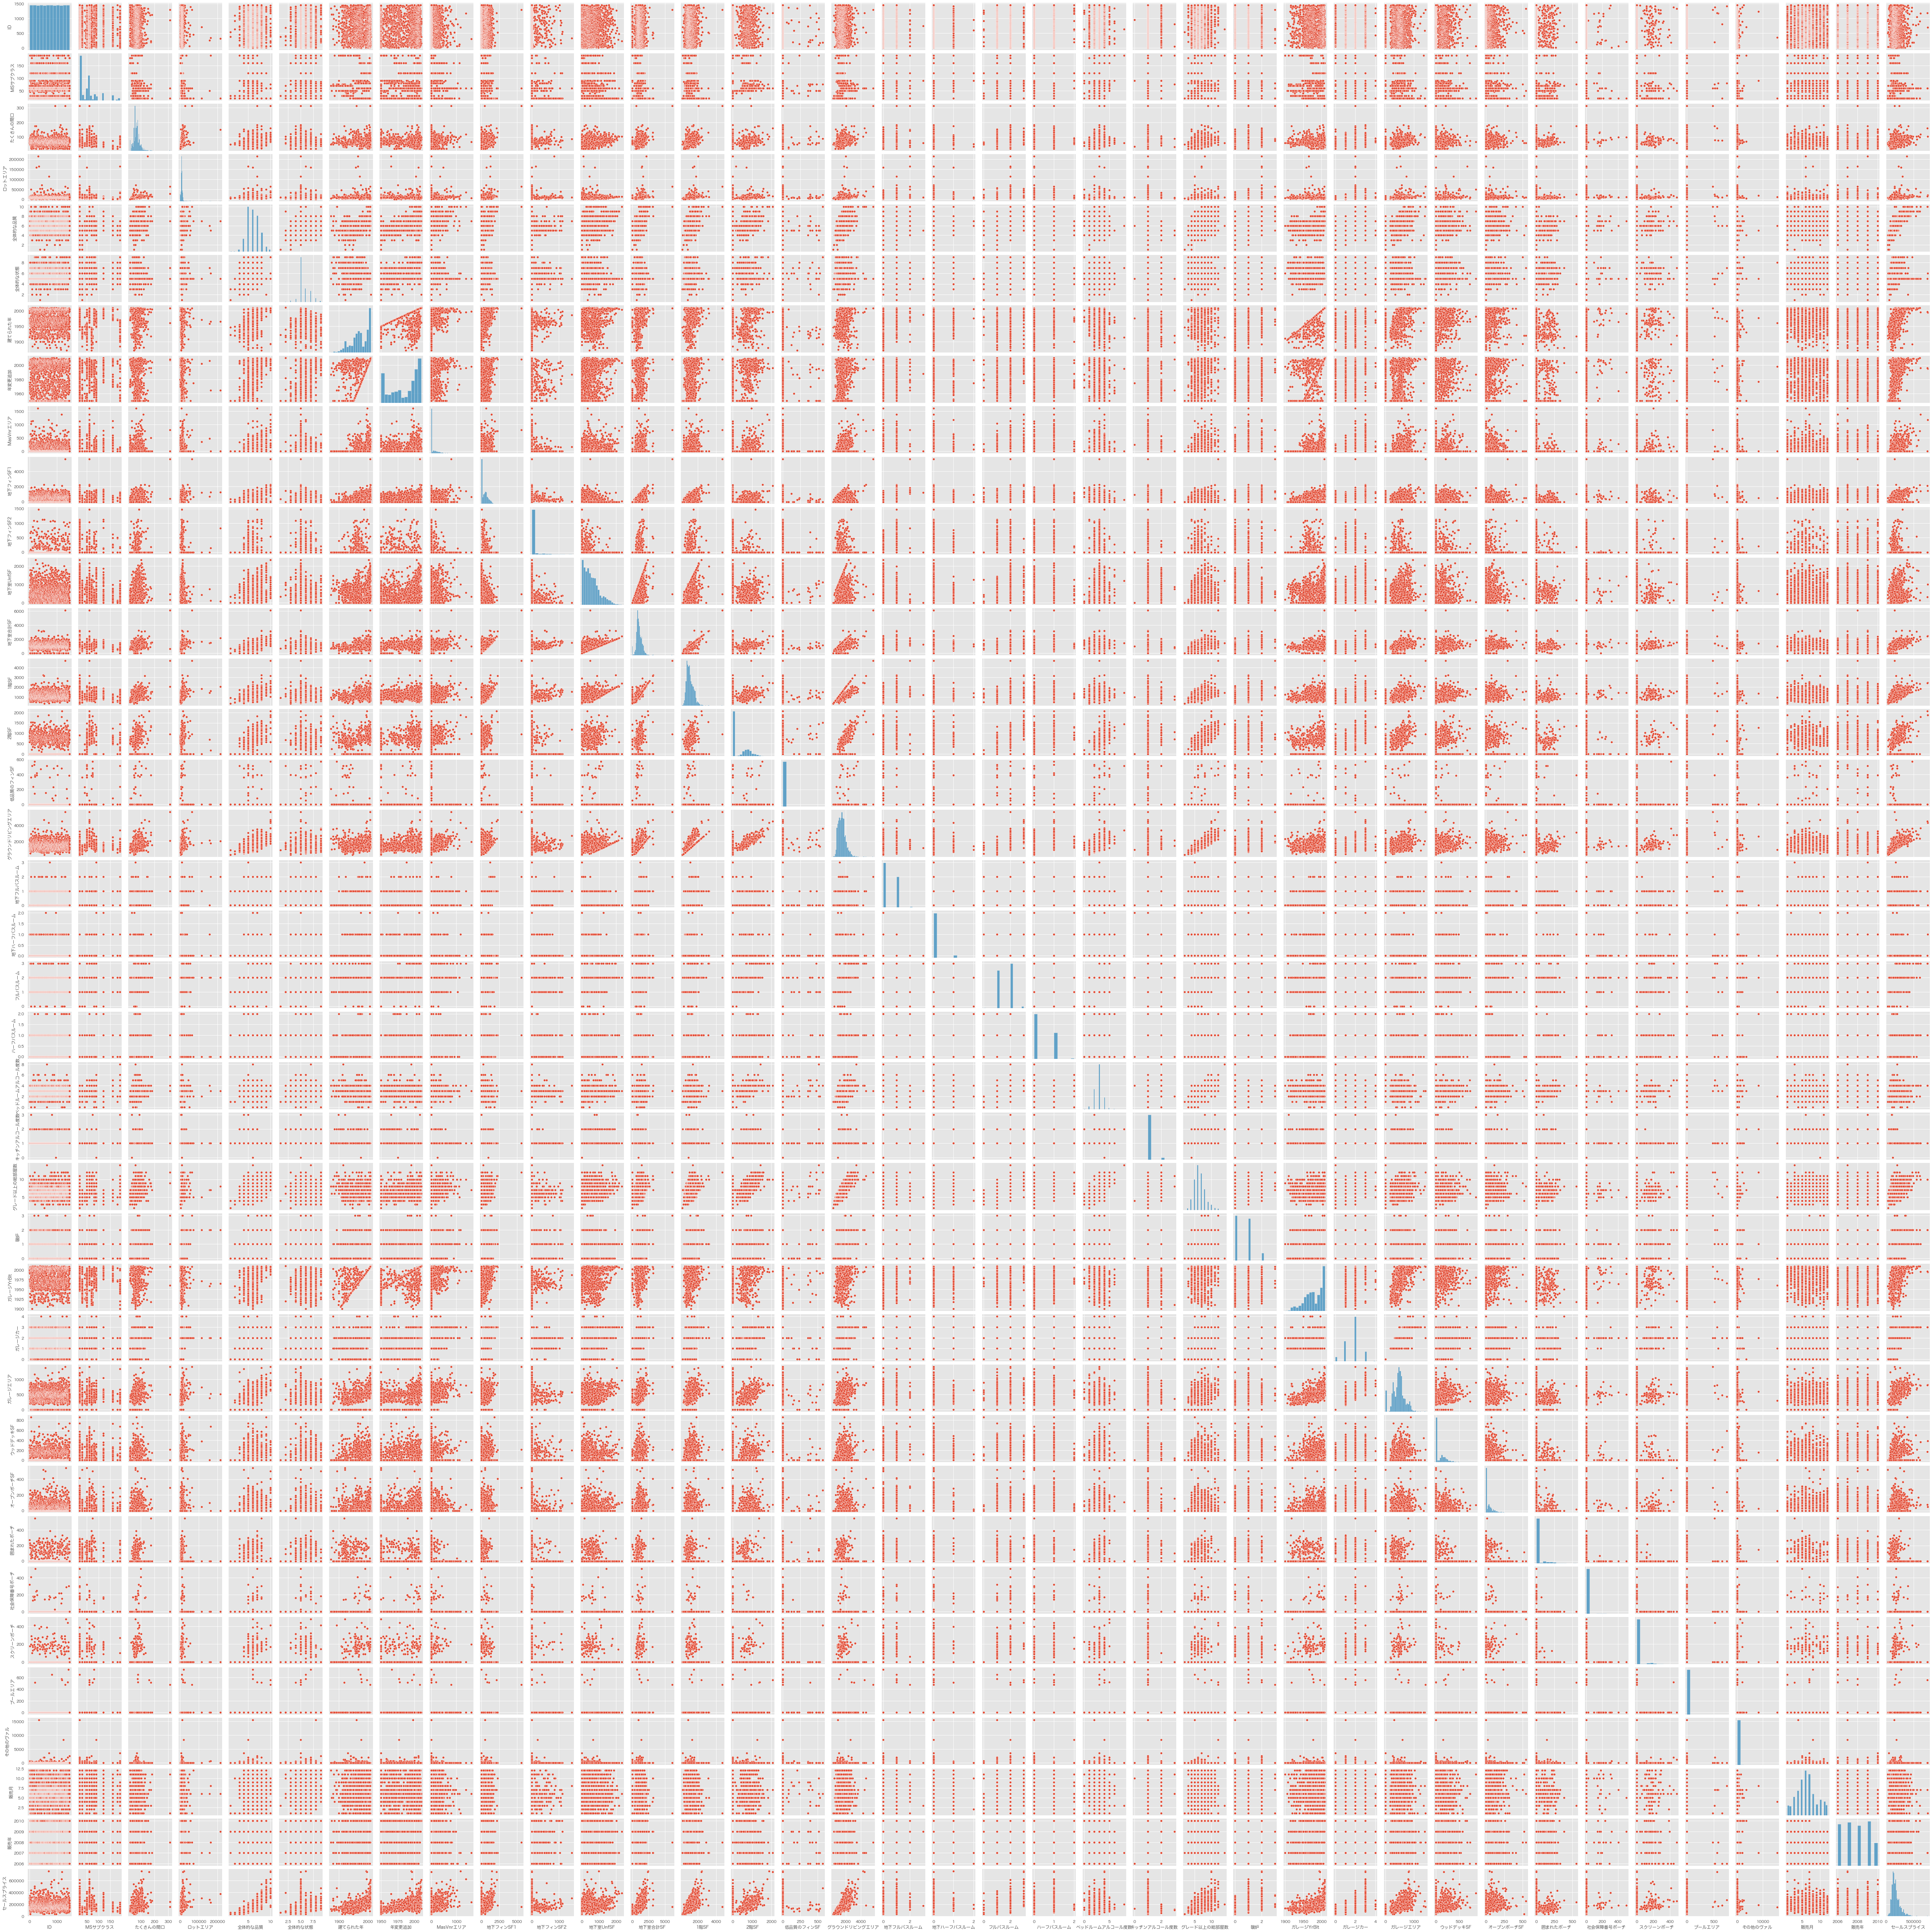

In [9]:
# 外れ値
# 散布図行列
# train
sns.pairplot(train_df, height=2);

In [10]:
# test
# sns.pairplot(test_df, height=2);

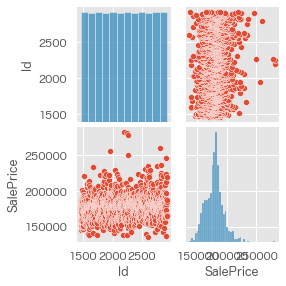

In [11]:
# sample_submission
sns.pairplot(sample_submission, height=2);

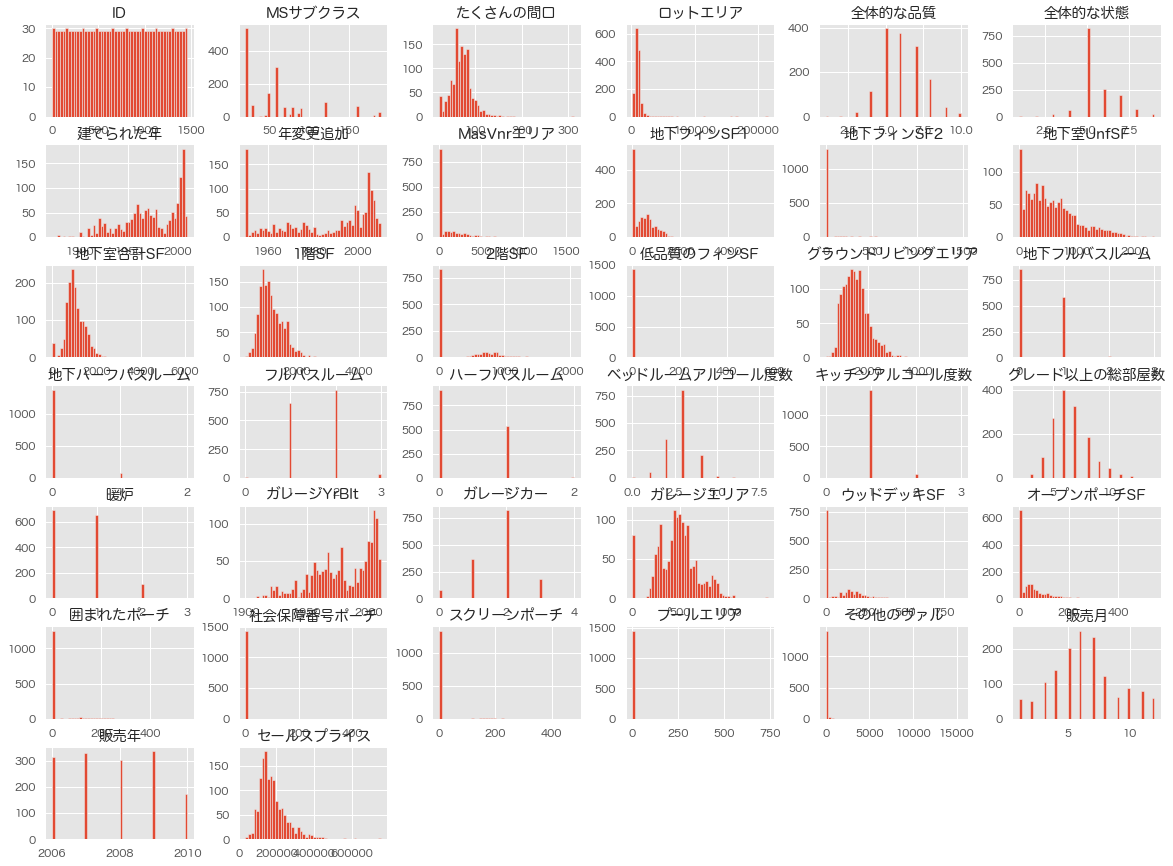

In [12]:
# ヒストグラムでデータ概略把握
train_df.hist(bins=50, figsize=(20,15))
plt.show();

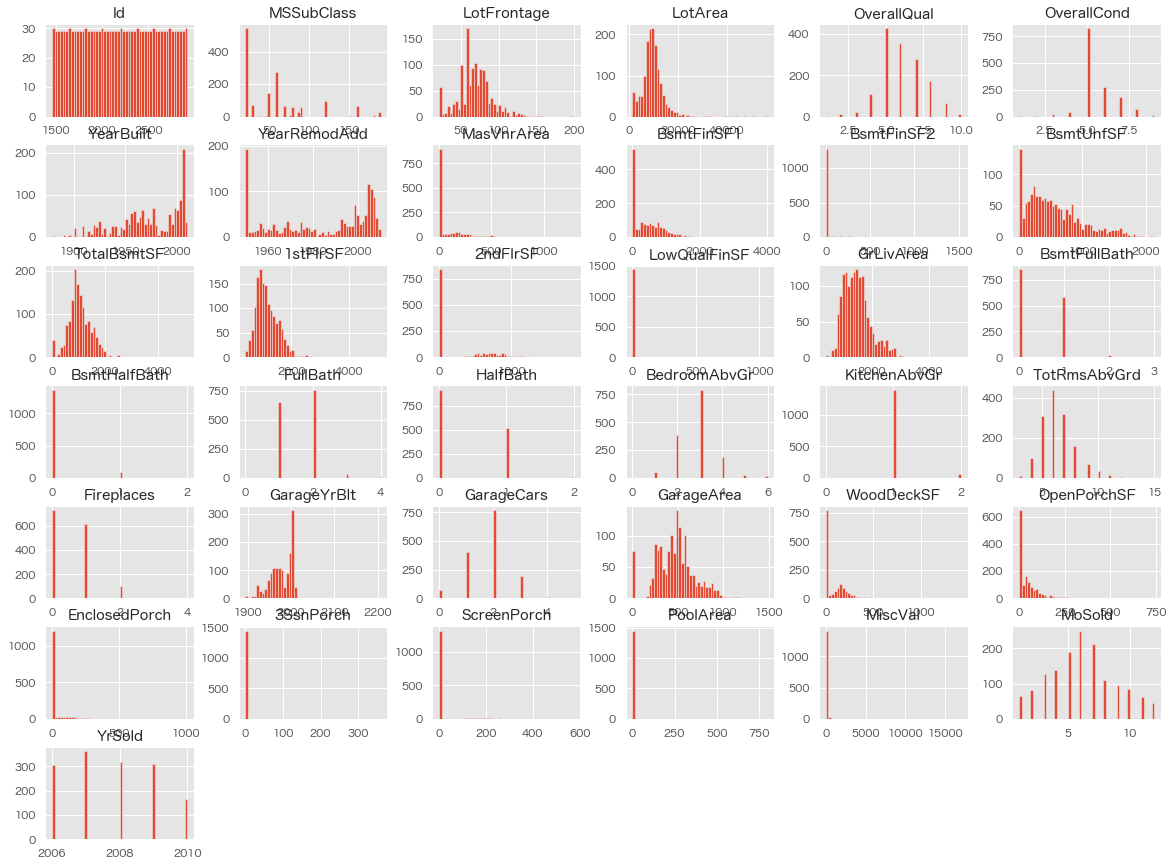

In [13]:
test_df.hist(bins=50, figsize=(20,15))
plt.show();

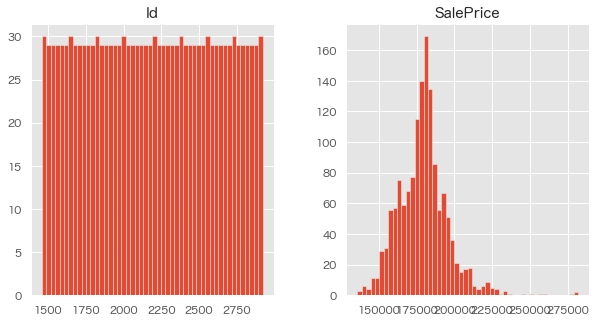

In [14]:
sample_submission.hist(bins=50, figsize=(10,5))
plt.show();

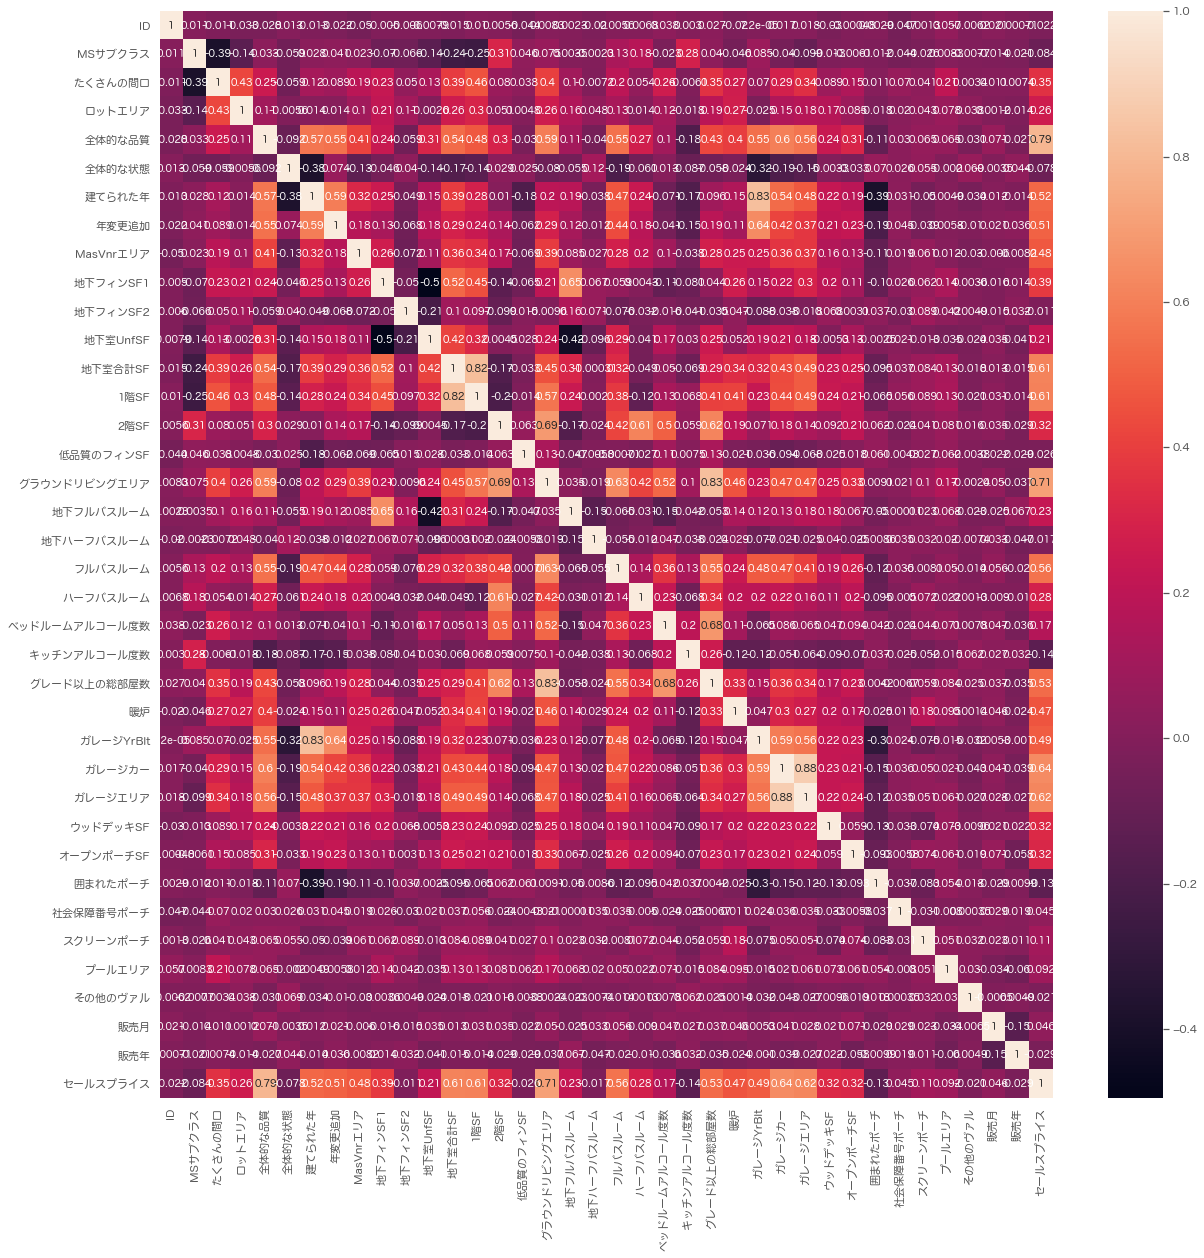

In [15]:
# 相関分析
# ヒートマップ
plt.figure(figsize=(20, 20))
sns.heatmap(pd.DataFrame(train_df).corr(), annot=True);

In [16]:
# カテゴリ変数の探索、確認
train_df[['ID', 'MSサブクラス', 'MSエリア分割', 'たくさんの間口', 'ロットエリア', '街', '路地', 'ロット形状','土地の等高線', 'ユーティリティ', 'ロット構成', '土地の傾斜', '近所', '状態1', '条件2', 'ビルタイプ']].head(3)
train_df[['ハウススタイル', '全体的な品質', '全体的な状態', '建てられた年', '年変更追加', 'ルーフスタイル', 'ルーフマット','エクステリア1位', 'エクステリア2位', 'MasVnrタイプ', 'MasVnrエリア', '外部の品質', '外部の条件']].head(3)
train_df[['財団', '地下室の品質', '地下室の状態', '地下室の露出', '地下室のフィンタイプ1', '地下フィンSF1', '地下室のフィンタイプ2','地下フィンSF2', '地下室UnfSF', '地下室合計SF', '暖房', '暖房品質管理', 'セントラルエア', '電気']].head(3)
train_df[['1階SF', '2階SF', '低品質のフィンSF', 'グラウンドリビングエリア', '地下フルバスルーム', '地下ハーフバスルーム','フルバスルーム', 'ハーフバスルーム', 'ベッドルームアルコール度数', 'キッチンアルコール度数', 'キッチンクォール']].head(3)
train_df[[ 'グレード以上の総部屋数', '機能的', '暖炉', '暖炉の品質', 'ガレージタイプ', 'ガレージYrBlt', 'ガレージ仕上げ','ガレージカー', 'ガレージエリア', 'ガレージの品質', 'ガレージコンディション', '舗装されたドライブ', 'ウッドデッキSF']].head(3)
train_df[['オープンポーチSF', '囲まれたポーチ', '社会保障番号ポーチ', 'スクリーンポーチ', 'プールエリア', 'プールの品質管理','フェンス', 'その他の機能', 'その他のヴァル', '販売月', '販売年', '販売タイプ', '販売条件', 'セールスプライス']].head(3)

ID  MSサブクラス MSエリア分割  たくさんの間口  ロットエリア     街   路地 ロット形状 土地の等高線 ユーティリティ  \
0   1       60      RL       65    8450  Pave  NaN   Reg    Lvl  AllPub   
1   2       20      RL       80    9600  Pave  NaN   Reg    Lvl  AllPub   
2   3       60      RL       68   11250  Pave  NaN   IR1    Lvl  AllPub   

    ロット構成 土地の傾斜       近所    状態1   条件2 ビルタイプ  
0  Inside   Gtl  CollgCr   Norm  Norm  1Fam  
1     FR2   Gtl  Veenker  Feedr  Norm  1Fam  
2  Inside   Gtl  CollgCr   Norm  Norm  1Fam

ハウススタイル  全体的な品質  全体的な状態  建てられた年  年変更追加 ルーフスタイル   ルーフマット エクステリア1位 エクステリア2位  \
0  2Story       7       5    2003   2003   Gable  CompShg  VinylSd  VinylSd   
1  1Story       6       8    1976   1976   Gable  CompShg  MetalSd  MetalSd   
2  2Story       7       5    2001   2002   Gable  CompShg  VinylSd  VinylSd   

  MasVnrタイプ  MasVnrエリア 外部の品質 外部の条件  
0   BrkFace        196    Gd    TA  
1      None          0    TA    TA  
2   BrkFace        162    Gd    TA

財団 地下室の品質 地下室の状態 地下室の露出 地下室のフィンタイプ1  地下フィンSF1 地下室のフィンタイプ2  地下フィンSF2  \
0   PConc     Gd     TA     No         GLQ       706         Unf         0   
1  CBlock     Gd     TA     Gd         ALQ       978         Unf         0   
2   PConc     Gd     TA     Mn         GLQ       486         Unf         0   

   地下室UnfSF  地下室合計SF    暖房 暖房品質管理 セントラルエア     電気  
0       150      856  GasA     Ex       Y  SBrkr  
1       284     1262  GasA     Ex       Y  SBrkr  
2       434      920  GasA     Ex       Y  SBrkr

1階SF  2階SF  低品質のフィンSF  グラウンドリビングエリア  地下フルバスルーム  地下ハーフバスルーム  フルバスルーム  \
0   856   854          0          1710          1           0        2   
1  1262     0          0          1262          0           1        2   
2   920   866          0          1786          1           0        2   

   ハーフバスルーム  ベッドルームアルコール度数  キッチンアルコール度数 キッチンクォール  
0         1              3            1       Gd  
1         0              3            1       TA  
2         1              3            1       Gd

グレード以上の総部屋数  機能的  暖炉 暖炉の品質 ガレージタイプ  ガレージYrBlt ガレージ仕上げ  ガレージカー  ガレージエリア  \
0            8  Typ   0   NaN  Attchd       2003     RFn       2      548   
1            6  Typ   1    TA  Attchd       1976     RFn       2      460   
2            6  Typ   1    TA  Attchd       2001     RFn       2      608   

  ガレージの品質 ガレージコンディション 舗装されたドライブ  ウッドデッキSF  
0      TA          TA         Y         0  
1      TA          TA         Y       298  
2      TA          TA         Y         0

オープンポーチSF  囲まれたポーチ  社会保障番号ポーチ  スクリーンポーチ  プールエリア プールの品質管理 フェンス その他の機能  \
0         61        0          0         0       0      NaN  NaN    NaN   
1          0        0          0         0       0      NaN  NaN    NaN   
2         42        0          0         0       0      NaN  NaN    NaN   

   その他のヴァル  販売月   販売年 販売タイプ    販売条件  セールスプライス  
0        0    2  2008    WD  Normal    208500  
1        0    5  2007    WD  Normal    181500  
2        0    9  2008    WD  Normal    223500

- 名義尺度  
状態1  
地下室のフィンタイプ1
販売条件  

- 順序尺度  
全体的な品質  
地下室の状態  

- バイナリ（2値）  
暖炉

In [17]:
# 欠損値の再確認
missing_values1[['状態1', '地下室のフィンタイプ1', '販売条件', '全体的な品質', '外部の品質', '地下室の状態']].T

0
状態1           0
地下室のフィンタイプ1  37
販売条件          0
全体的な品質        0
外部の品質         0
地下室の状態       37

In [18]:
# データ型=object、の項目
categorical_columns = [c for c in train_df.columns if (train_df[c].dtype == 'object')]
categorical_columns

['MSエリア分割',
 '街',
 '路地',
 'ロット形状',
 '土地の等高線',
 'ユーティリティ',
 'ロット構成',
 '土地の傾斜',
 '近所',
 '状態1',
 '条件2',
 'ビルタイプ',
 'ハウススタイル',
 'ルーフスタイル',
 'ルーフマット',
 'エクステリア1位',
 'エクステリア2位',
 'MasVnrタイプ',
 '外部の品質',
 '外部の条件',
 '財団',
 '地下室の品質',
 '地下室の状態',
 '地下室の露出',
 '地下室のフィンタイプ1',
 '地下室のフィンタイプ2',
 '暖房',
 '暖房品質管理',
 'セントラルエア',
 '電気',
 'キッチンクォール',
 '機能的',
 '暖炉の品質',
 'ガレージタイプ',
 'ガレージ仕上げ',
 'ガレージの品質',
 'ガレージコンディション',
 '舗装されたドライブ',
 'プールの品質管理',
 'フェンス',
 'その他の機能',
 '販売タイプ',
 '販売条件']

In [19]:
# 各変数の要素の出現頻度
train_df['状態1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: 状態1, dtype: int64

In [20]:
train_df['地下室のフィンタイプ1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: 地下室のフィンタイプ1, dtype: int64

In [21]:
train_df['販売条件'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: 販売条件, dtype: int64

In [22]:
train_df['全体的な品質'].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: 全体的な品質, dtype: int64

In [23]:
train_df['外部の品質'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: 外部の品質, dtype: int64

In [24]:
train_df['地下室の状態'].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: 地下室の状態, dtype: int64

# エンコーディング

## One-Hotエンコーディング

In [25]:
train_df['状態1'].value_counts()

train_oh = pd.DataFrame()
train_oh = pd.get_dummies(train_df['状態1'], prefix='状態1', prefix_sep='_')
train_oh.shape
train_oh.head(10)

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: 状態1, dtype: int64

(1460, 9)

状態1_Artery  状態1_Feedr  状態1_Norm  状態1_PosA  状態1_PosN  状態1_RRAe  状態1_RRAn  \
0           0          0         1         0         0         0         0   
1           0          1         0         0         0         0         0   
2           0          0         1         0         0         0         0   
3           0          0         1         0         0         0         0   
4           0          0         1         0         0         0         0   
5           0          0         1         0         0         0         0   
6           0          0         1         0         0         0         0   
7           0          0         0         0         1         0         0   
8           1          0         0         0         0         0         0   
9           1          0         0         0         0         0         0   

   状態1_RRNe  状態1_RRNn  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         0         0  
6         0         0  
7         0         0  
8         0         0  
9         0         0

[状態1]の9個の項目値を用いて、ダミー変数を作成できた。

## ダミーコーディング

In [26]:
train_df['状態1'].value_counts()

train_dm = pd.DataFrame()
train_dm = pd.get_dummies(train_df['状態1'], prefix='状態1', prefix_sep='_', drop_first = True)
train_dm.shape
train_dm.head(10)

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: 状態1, dtype: int64

(1460, 8)

状態1_Feedr  状態1_Norm  状態1_PosA  状態1_PosN  状態1_RRAe  状態1_RRAn  状態1_RRNe  \
0          0         1         0         0         0         0         0   
1          1         0         0         0         0         0         0   
2          0         1         0         0         0         0         0   
3          0         1         0         0         0         0         0   
4          0         1         0         0         0         0         0   
5          0         1         0         0         0         0         0   
6          0         1         0         0         0         0         0   
7          0         0         0         1         0         0         0   
8          0         0         0         0         0         0         0   
9          0         0         0         0         0         0         0   

   状態1_RRNn  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         0  
7         0  
8         0  
9         0

[状態1]の「９-1=8」個の項目値を用いて、ダミー変数を作成できた。

## Effectコーディング

In [27]:
train_ef = train_dm.copy()
train_ef['状態1_Norm'] = train_ef['状態1_Norm'].where(train_ef['状態1_Feedr'] == 0, -1) # 条件の結果がFalseの値を置換

train_ef[['状態1_Feedr', '状態1_Norm']].head(10)

状態1_Feedr  状態1_Norm
0          0         1
1          1        -1
2          0         1
3          0         1
4          0         1
5          0         1
6          0         1
7          0         0
8          0         0
9          0         0

## Labelエンコーディング

In [28]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OrdinalEncoder
# LabelBinarizer : 2値のラベル分類
# LabelEncoder : 3値以上のラベル分類

train_df['外部の品質'].value_counts()
train_lbl = train_df.copy()

lbl = LabelEncoder()
train_lbl['外部の品質_enc'] = lbl.fit_transform(train_df['外部の品質'])
train_lbl[['外部の品質', '外部の品質_enc']].head()

TA    906
Gd    488
Ex     52
Fa     14
Name: 外部の品質, dtype: int64

外部の品質  外部の品質_enc
0    Gd          2
1    TA          3
2    Gd          2
3    TA          3
4    Gd          2

  
バイナリデータがデータセットに含まれていない為、他のデータセットで「LabelBinarizer」を試すことにする。  

## Ordinalエンコーディング

In [29]:
map_dict = {'TA': 0, 'Gd': 1, 'Ex': 2, 'Fa': 3}
def map_values(x):
    return map_dict[x]

train_oe = train_df.copy()
train_oe['外部の品質_oe'] = train_oe['外部の品質'].apply(lambda x: map_values(x))
train_oe[['外部の品質', '外部の品質_oe']].tail()

外部の品質  外部の品質_oe
1455    TA         0
1456    TA         0
1457    Ex         2
1458    TA         0
1459    Gd         1

In [31]:
from sklearn.preprocessing import OrdinalEncoder
# OrdinalEncoder : 複数項目に対する、一括ラベルエンコーディング

train_oe = train_df.copy()
oe = OrdinalEncoder()
train_oe[['外部の品質_oe', '外部の条件_oe']] = oe.fit_transform(train_df[['外部の品質', '外部の条件']]) # 欠損値不可
train_oe[['外部の品質', '外部の品質_oe', '外部の条件', '外部の条件_oe']].tail()

train_df['外部の品質'].value_counts()
train_oe['外部の品質_oe'].value_counts()
print('='*30)
train_df['外部の条件'].value_counts()
train_oe['外部の条件_oe'].value_counts()

外部の品質  外部の品質_oe 外部の条件  外部の条件_oe
1455    TA         3    TA         4
1456    TA         3    TA         4
1457    Ex         0    Gd         2
1458    TA         3    TA         4
1459    Gd         2    TA         4

TA    906
Gd    488
Ex     52
Fa     14
Name: 外部の品質, dtype: int64

3    906
2    488
0     52
1     14
Name: 外部の品質_oe, dtype: int64

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: 外部の条件, dtype: int64

4    1282
2     146
1      28
0       3
3       1
Name: 外部の条件_oe, dtype: int64

In [41]:
import category_encoders as ce
oe = ce.OrdinalEncoder()
# パラメータ：「cols」および「handle_unknown」は、将来削除されることになった為、非推奨
# cols : 対象の項目名を指定
# handle_unknown : 実行中のエラーを表示させる

train_oe2 = train_df.copy()
train_oe2 = oe.fit_transform(train_df['外部の品質'])

pd.concat([train_oe2['外部の品質'].rename('外部の品質_after')], axis=1).head()

外部の品質_after
0            1
1            2
2            1
3            2
4            1

## Feature hashing

In [110]:
from sklearn.feature_extraction import FeatureHasher
from sys import getsizeof

tgt = train_df['全体的な品質'].astype('str')
tgt.value_counts()
m = len(tgt.unique()) # 要素数
print(f'要素数（次元数）：　{m}')

h = FeatureHasher(n_features=m, input_type='string')
f = h.transform(tgt)
f.toarray()

tgt.shape
f.shape

getsizeof(tgt)
getsizeof(f)

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: 全体的な品質, dtype: int64

要素数（次元数）：　10


array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

(1460,)

(1460, 10)

84842

48

In [113]:
# 1次元に圧縮
h = FeatureHasher(n_features=1, input_type='string')
f = h.transform(tgt)
f.toarray()

tgt.shape
f.shape

getsizeof(tgt)
getsizeof(f)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

(1460,)

(1460, 1)

84842

48

## カウント（Frequency）エンコーディング

In [128]:
count_df = train_df.copy()

count_map = count_df['全体的な品質'].value_counts().to_dict()
count_map
count_df['全体的な品質_cnt'] = count_df['全体的な品質'].map(count_map)
count_df[['全体的な品質', '全体的な品質_cnt']].head()

{5: 397, 6: 374, 7: 319, 8: 168, 4: 116, 9: 43, 3: 20, 10: 18, 2: 3, 1: 2}

全体的な品質  全体的な品質_cnt
0       7         319
1       6         374
2       7         319
3       7         319
4       8         168

## Count label（Ranked frequency）エンコーディング

In [129]:
rank_df = train_df.copy()

rank_map = rank_df['全体的な品質'].value_counts().rank(ascending=False).to_dict()
rank_map
rank_df['全体的な品質_cnt'] = count_df['全体的な品質'].map(rank_map)
rank_df[['全体的な品質', '全体的な品質_cnt']].head()

{5: 1.0,
 6: 2.0,
 7: 3.0,
 8: 4.0,
 4: 5.0,
 9: 6.0,
 3: 7.0,
 10: 8.0,
 2: 9.0,
 1: 10.0}

全体的な品質  全体的な品質_cnt
0       7           3
1       6           2
2       7           3
3       7           3
4       8           4

## ビンカウンティング

In [184]:
bin_count = train_df.copy()

bin_df = pd.DataFrame()
taeget = bin_count.groupby('MSサブクラス').agg({'暖炉': 'mean'})
bin_df = pd.merge(bin_count, taeget, on='MSサブクラス', right_index=True)[['MSサブクラス', '暖炉_y']].astype(str)
bin_df.head()
bin_df.tail()

MSサブクラス                暖炉_y
0       60  0.8862876254180602
2       60  0.8862876254180602
4       60  0.8862876254180602
7       60  0.8862876254180602
11      60  0.8862876254180602

MSサブクラス 暖炉_y
1452     180  0.0
164       40  0.5
589       40  0.5
873       40  0.5
1270      40  0.5

## Nonエンコーディング

In [139]:
# 欠損値の再確認
num = missing_values1['地下室の状態'].T.values[0]
print(f'欠損値の数：　{num}')
# 要素の確認
train_df['地下室の状態'].value_counts()

train_non = pd.DataFrame()
train_non = pd.get_dummies(train_df['地下室の状態'], prefix='地下室の状態', prefix_sep='_', drop_first = True, dummy_na=True)
train_non.shape
train_non.head(10)

欠損値の数：　37


TA    1311
Gd      65
Fa      45
Po       2
Name: 地下室の状態, dtype: int64

(1460, 4)

地下室の状態_Gd  地下室の状態_Po  地下室の状態_TA  地下室の状態_nan
0          0          0          1           0
1          0          0          1           0
2          0          0          1           0
3          1          0          0           0
4          0          0          1           0
5          0          0          1           0
6          0          0          1           0
7          0          0          1           0
8          0          0          1           0
9          0          0          1           0

In [170]:
# 欠損値の再確認
num = missing_values1['地下室の状態'].T.values[0]
print(f'欠損値の数：　{num}')

train_oe = train_df['地下室の状態'].copy()
train_oe = train_oe.fillna('Other')

num = train_oe[train_oe.isnull()].count()
print(f'欠損値の数：　{num}')

map_dict = {'TA': 0, 'Gd': 1, 'Po': 2, 'Fa': 3, 'Other': 4}
def map_values(x):
    return map_dict[x]

train_oe = train_oe.apply(lambda x: map_values(x))

train_df['地下室の状態'].value_counts().sort_values()
train_oe.value_counts().sort_values()

欠損値の数：　37
欠損値の数：　0


Po       2
Fa      45
Gd      65
TA    1311
Name: 地下室の状態, dtype: int64

2       2
4      37
3      45
1      65
0    1311
Name: 地下室の状態, dtype: int64